# Example optimisation w/ nonlocal mods

Take timing.

In [1]:
from time import time

tic = time()

## Imports and prep

In [2]:
from ship_routing.core import Route, WayPoint
from ship_routing.currents import load_currents
from ship_routing.algorithms import (
    gradient_descent_across_track_left,
    gradient_descent_along_track,
    gradient_descent_time_shift,
    LargeIncrementError,
    InvalidGradientError,
    ZeroGradientsError,
)

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm

In [4]:
np.random.seed(345)

## Load currents and plot speed

In [5]:
currents = load_currents(
    data_file="data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_100W-020E_10N-65N.nc"
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.Dataset> Size: 10MB
Dimensions:  (lat: 661, lon: 1321, time: 1)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 8B 2021-01-01
Data variables:
    uo       (time, lat, lon) float32 3MB -0.1356 -0.1479 ... 0.07963 0.05846
    vo       (time, lat, lon) float32 3MB -0.01258 -0.02277 ... 0.2739 0.4073
    speed    (time, lat, lon) float32 3MB 0.1362 0.1497 0.163 ... 0.2852 0.4115
Attributes:
    Conventions:  CF-1.8
    area:         Global
    contact:      https://marine.copernicus.eu/contact
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    institution:  Mercator Ocean International
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    references:   http://marine.copernicus.eu
    source:       MOI GLO12
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...

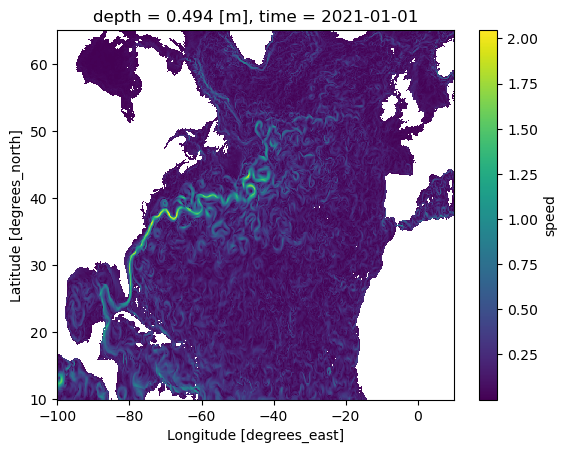

In [6]:
currents.speed.plot()

## Define a route and have a look

In [7]:
route_0 = Route(
    way_points=(
        WayPoint(lon=-80.5, lat=30, time=np.datetime64("2021-01-01")),
        WayPoint(lon=-10, lat=50, time=np.datetime64("2021-01-11")),
    )
)
# refine to 12 hourly way points
refine_to = np.mean([l.speed_ms for l in route_0.legs]) * 12 * 3600.0
route_0 = route_0.refine(distance_meters=refine_to)
route_0

Route(way_points=(WayPoint(lon=-80.5, lat=30, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-78.098519636058, lat=31.855837618895183, time=numpy.datetime64('2021-01-01T11:59:59.999')), WayPoint(lon=-75.60015737467967, lat=33.6639713948614, time=numpy.datetime64('2021-01-01T23:59:59.999')), WayPoint(lon=-72.99663283537555, lat=35.41896272444271, time=numpy.datetime64('2021-01-02T11:59:59.999')), WayPoint(lon=-70.27967718012803, lat=37.11487954484631, time=numpy.datetime64('2021-01-02T23:59:59.999')), WayPoint(lon=-67.44123126301778, lat=38.74527014071479, time=numpy.datetime64('2021-01-03T11:59:59.999')), WayPoint(lon=-64.47371094073974, lat=40.303149089749574, time=numpy.datetime64('2021-01-03T23:59:59.999')), WayPoint(lon=-61.37034871434607, lat=41.78100113563067, time=numpy.datetime64('2021-01-04T11:59:59.999')), WayPoint(lon=-58.12561687605418, lat=43.170809951530096, time=numpy.datetime64('2021-01-04T23:59:59.999')), WayPoint(lon=-54.73572989755354, lat=44.46411963593293, time

In [8]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 7.134894006504659


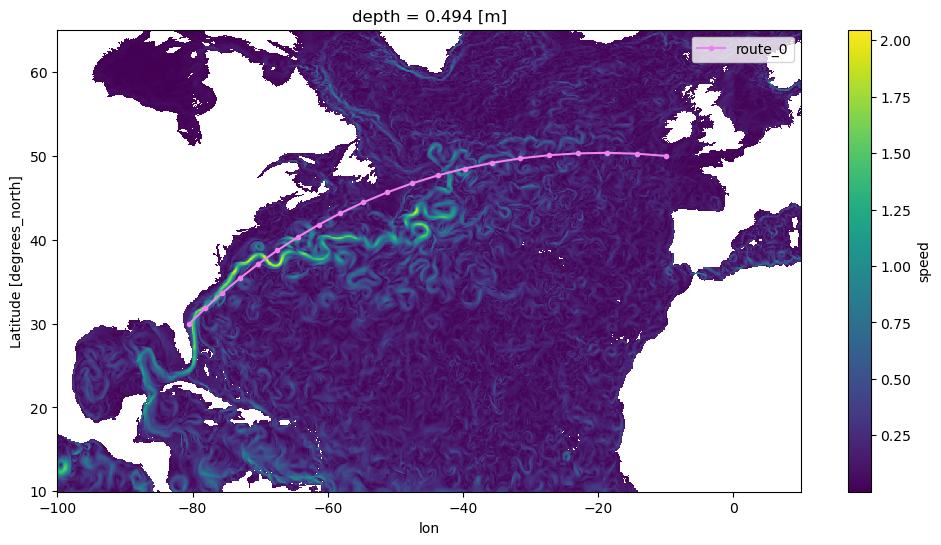

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
currents.speed.mean("time").plot(ax=ax)
route_0.data_frame.plot.line(
    x="lon", y="lat", marker=".", ax=ax, color="violet", label="route_0"
);

## Keep track of cost

In [10]:
cost_steps = []

## Stochastic Optimisation

In [11]:
max_width = 0.75 * route_0.length_meters
max_dist_mod = 0.75 * max_width
route_1 = route_0
cost = route_1.cost_through(currents)
cost_steps.append(cost)

accepted = 0
n_reset = 0
for n in tqdm.tqdm(range(1_000)):
    _route_1 = route_1.move_waypoints_left_nonlocal(
        center_distance_meters=np.random.uniform(
            max_width / 2.0, route_1.length_meters - max_width / 2.0
        ),
        width_meters=max_width,
        max_move_meters=np.random.uniform(-max_dist_mod, max_dist_mod),
    )
    _cost = _route_1.cost_through(current_data_set=currents)
    if not np.isnan(_cost) and _cost < cost:
        route_1 = _route_1
        cost = _cost
        accepted += 1
        cost_steps.append(cost)
    if (accepted + 1) / (n_reset + 1) < 0.05:
        n_reset = 0
        accepted = 0
        max_dist_mod /= 2.0**0.5
        max_width /= 2.0**0.5
        print(".")
    n_reset += 1

  4%|█▊                                       | 45/1000 [00:01<00:42, 22.51it/s]

.


  8%|███▍                                     | 84/1000 [00:03<00:40, 22.43it/s]

.


 10%|████▏                                   | 105/1000 [00:04<00:39, 22.54it/s]

.


 12%|████▉                                   | 123/1000 [00:05<00:38, 22.54it/s]

.


 14%|█████▊                                  | 144/1000 [00:06<00:37, 22.60it/s]

.


 26%|██████████▌                             | 264/1000 [00:11<00:33, 22.20it/s]

.


 30%|████████████                            | 303/1000 [00:13<00:30, 22.60it/s]

.


 96%|██████████████████████████████████████▌ | 963/1000 [00:42<00:01, 22.15it/s]

.


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.50it/s]


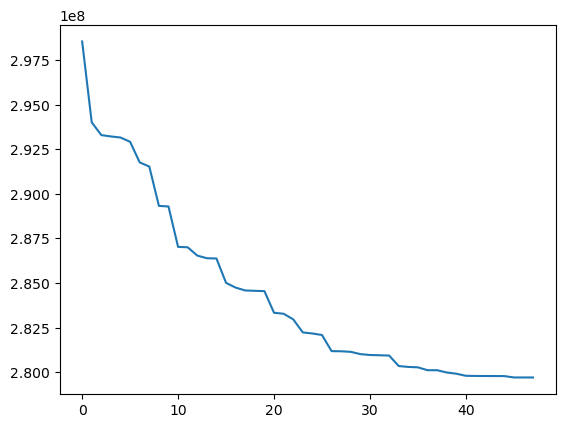

In [12]:
plt.plot(cost_steps)

## Show results

<Axes: title={'center': 'depth = 0.494 [m]'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

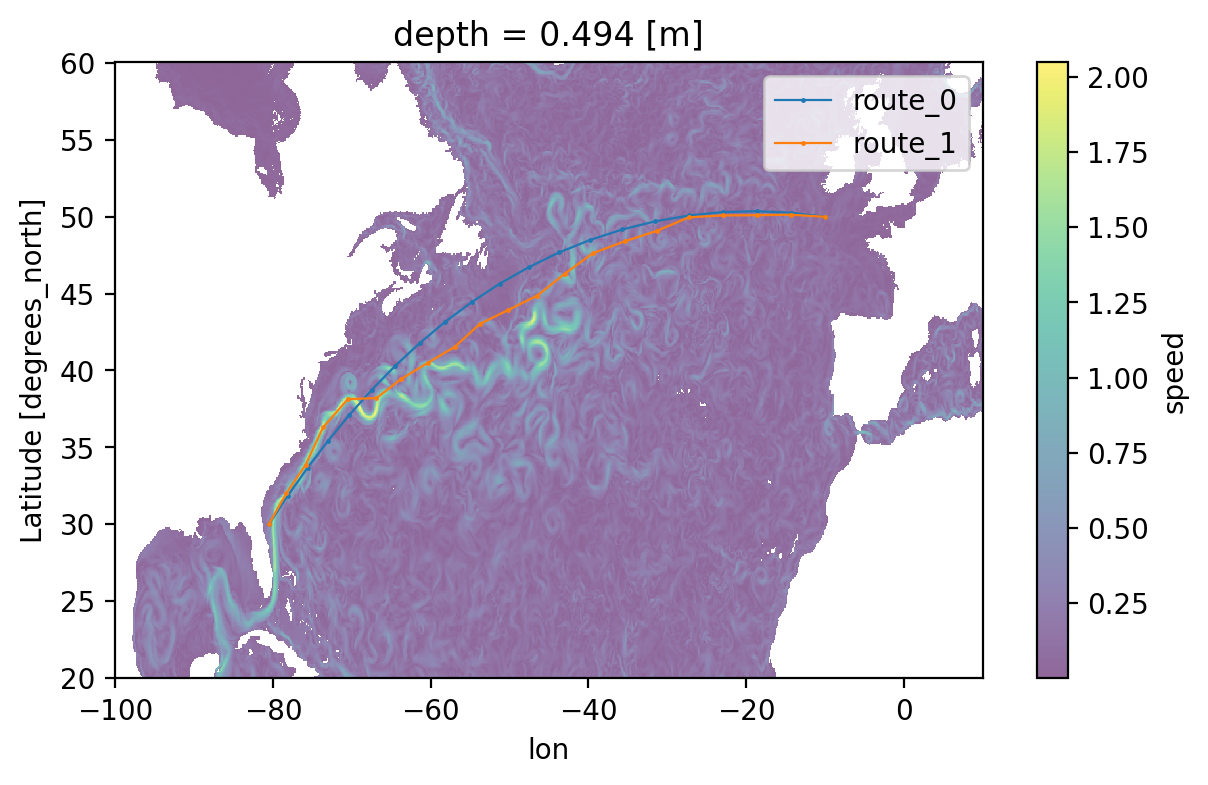

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
currents.speed.mean("time").sel(lon=slice(-100, 10), lat=slice(20, 60)).plot(
    ax=ax, alpha=0.6
)
fig.set_dpi(200)
route_0.data_frame.plot.line(
    x="lon", y="lat", marker=".", markersize=1.5, ax=ax, label="route_0", linewidth=0.8
)
route_1.data_frame.plot.line(
    x="lon", y="lat", marker=".", markersize=1.5, ax=ax, label="route_1", linewidth=0.8
)

In [14]:
print(
    "reduction",
    (route_1.cost_through(currents) - route_0.cost_through(currents))
    / route_0.cost_through(currents)
    * 100.0,
    "%"
)

reduction -6.304918581908671 %


In [15]:
print("length +", (route_1.length_meters - route_0.length_meters) / route_0.length_meters * 100.0, "%")

length + 1.572287726037686 %


## Gradient descents

In [16]:
learning_rate_percent_time = 0.2
time_increment = 1_200
learning_rate_percent_along = 0.2
dist_shift_along = 10_000
learning_rate_percent_across = 0.2
dist_shift_across = 10_000

route_2 = route_1
cost_steps_grad = []

for n in tqdm.tqdm(range(20)):
    try:
        route_2 = gradient_descent_time_shift(
            route=route_2,
            current_data_set=currents,
            time_shift_seconds=time_increment,
            learning_rate_percent=learning_rate_percent_time,
        )
        cost_steps_grad.append(route_2.cost_through(currents))
    except ZeroGradientsError:
        # converged, just pass
        pass
    except InvalidGradientError:
        time_increment /= 2.0
        learning_rate_percent_time /= 2.0
    except LargeIncrementError:
        learning_rate_percent_time /= 2.0

    try:
        route_2 = gradient_descent_across_track_left(
            route=route_2,
            current_data_set=currents,
            distance_meters=dist_shift_across,
            learning_rate_percent=learning_rate_percent_across,
        )
        cost_steps_grad.append(route_2.cost_through(currents))
    except ZeroGradientsError:
        # converged, just pass
        pass
    except InvalidGradientError:
        dist_shift_across /= 2.0
        learning_rate_percent_across /= 2.0
    except LargeIncrementError:
        learning_rate_percent_across /= 2.0

    try:
        route_2 = gradient_descent_along_track(
            route=route_2,
            current_data_set=currents,
            distance_meters=dist_shift_along,
            learning_rate_percent=learning_rate_percent_along,
        )
        cost_steps_grad.append(route_2.cost_through(currents))
    except ZeroGradientsError:
        # converged, just pass
        pass
    except InvalidGradientError:
        dist_shift_along /= 2.0
        learning_rate_percent_along /= 2.0
    except LargeIncrementError:
        learning_rate_percent_along /= 2.0

100%|███████████████████████████████████████████| 20/20 [01:42<00:00,  5.14s/it]


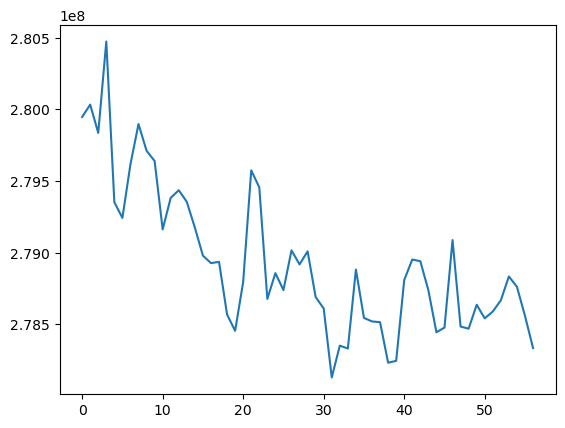

In [17]:
plt.plot(cost_steps_grad)

<Axes: title={'center': 'depth = 0.494 [m]'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

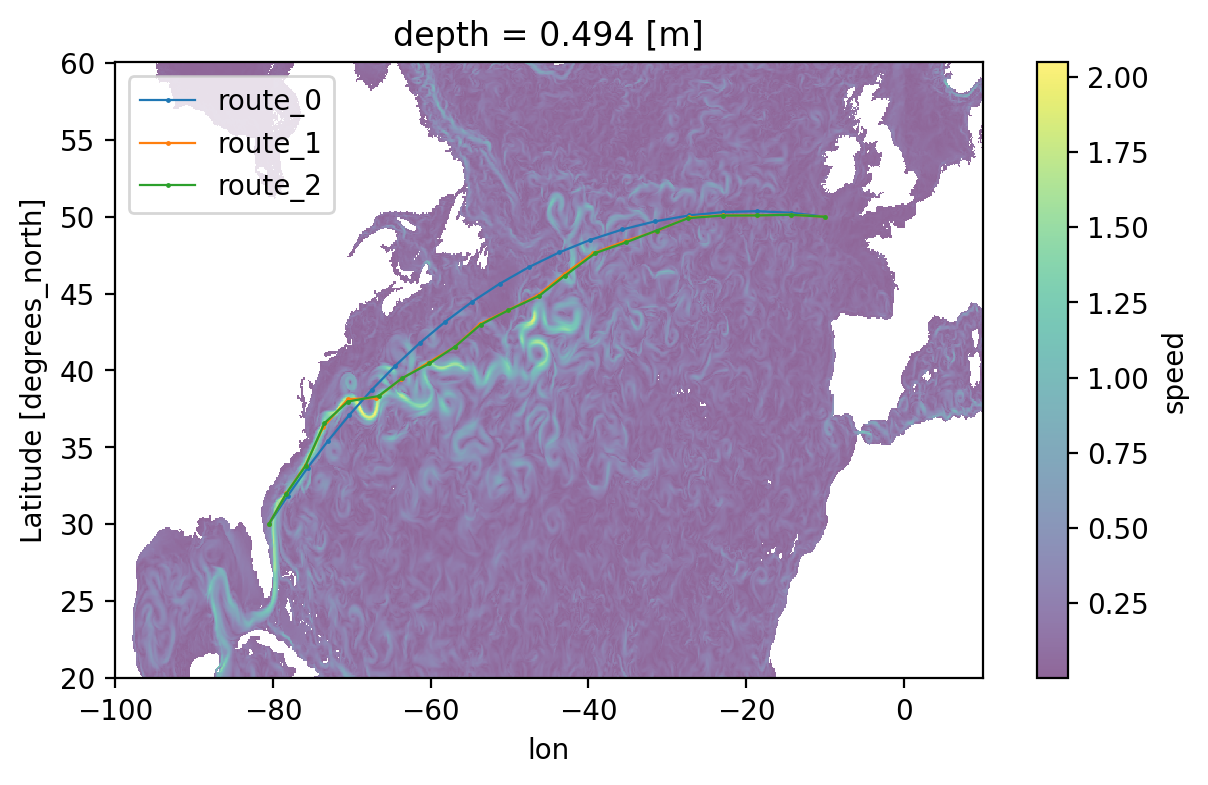

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
currents.speed.mean("time").sel(lon=slice(-100, 10), lat=slice(20, 60)).plot(
    ax=ax, alpha=0.6
)
fig.set_dpi(200)
route_0.data_frame.plot.line(
    x="lon", y="lat", marker=".", markersize=1.5, ax=ax, label="route_0", linewidth=0.8
)
route_1.data_frame.plot.line(
    x="lon", y="lat", marker=".", markersize=1.5, ax=ax, label="route_1", linewidth=0.8
)

route_2.data_frame.plot.line(
    x="lon", y="lat", marker=".", markersize=1.5, ax=ax, label="route_2", linewidth=0.8
)

In [19]:
print(
    "reduction",
    (route_2.cost_through(currents) - route_0.cost_through(currents))
    / route_0.cost_through(currents)
    * 100.0,
    "%"
)

reduction -6.76713463651562 %


In [20]:
print("length +", (route_2.length_meters - route_0.length_meters) / route_0.length_meters * 100.0, "%")

length + 1.4697202347969227 %


<BarContainer object of 20 artists>

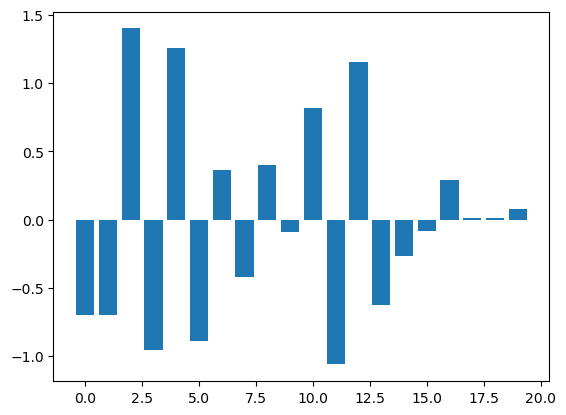

In [21]:
plt.bar(
    np.arange(len(route_2.legs)),
    (
        np.array([l.duration_seconds for l in route_2.legs]) 
        - np.mean([l.duration_seconds for l in route_2.legs])
    ) / 3600.0
)

## Timing

In [22]:
print("took", time() - tic, "seconds")

took 156.86219882965088 seconds
